In [152]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import tensorflow as tf
tf.__version__

'1.14.1'

In [1]:
import os
import matplotlib.pyplot as plt
import json
import math

In [3]:
split = 'val'

In [208]:
split = 'train'

In [4]:
split = 'test'

In [23]:
output_dir = "eraserbenchmark/outputs/lambda_sweep/"
img_dir = 'graphics/'
color = {'macro-avg-F1': 'r', 'sufficiency': 'g', 'comprehensiveness': 'b', 'auprc':'black'}
linestyles = {'macro-avg-F1': '-', 'sufficiency': '-', "comprehensiveness": ':', 'auprc':'-'}
markers = {'macro-avg-F1': 'o', 'sufficiency': 'D', 'comprehensiveness': 's', 'auprc': '^'}

In [16]:
from matplotlib import rc
rc('font',**{'family':'DejaVu Sans','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
linewidth=3

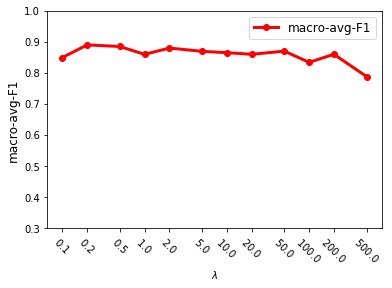

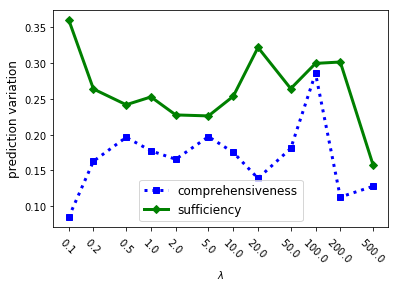

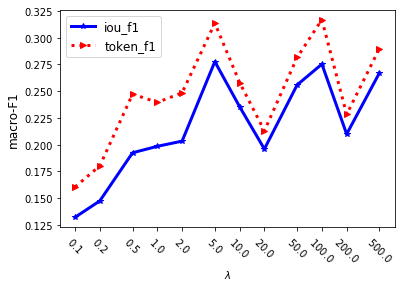

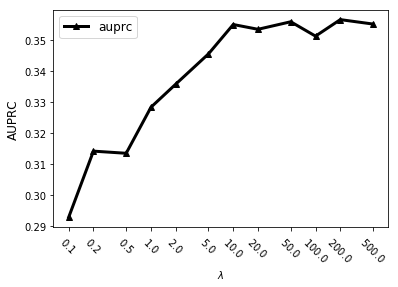

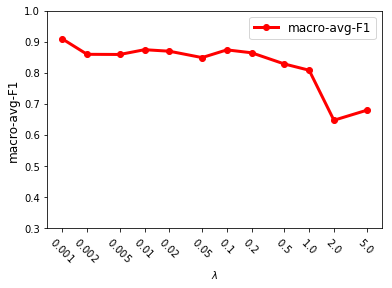

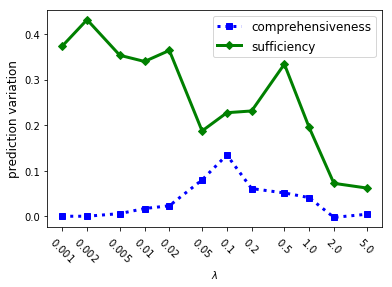

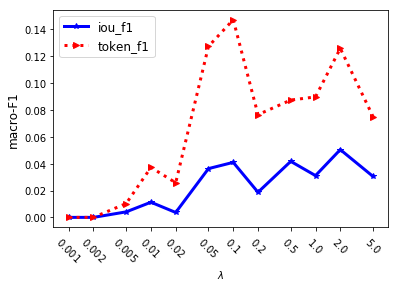

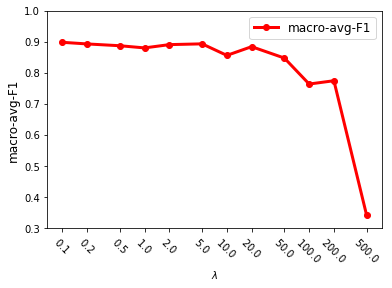

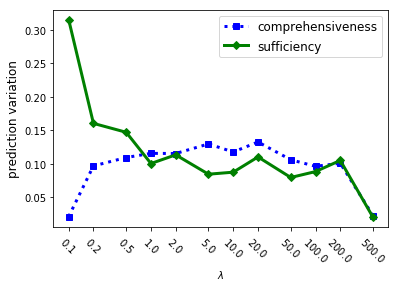

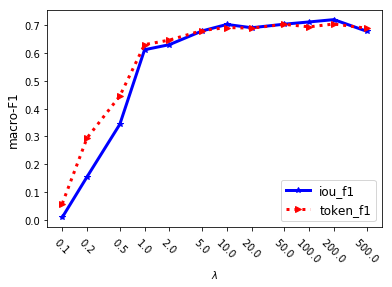

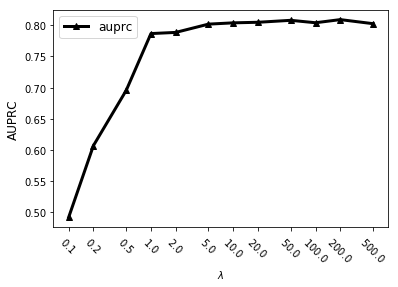

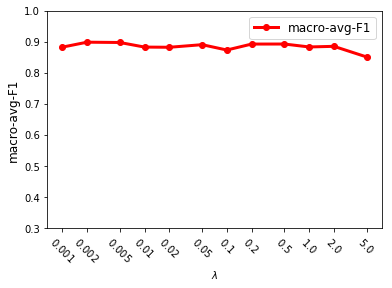

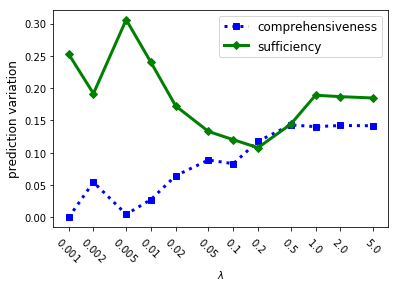

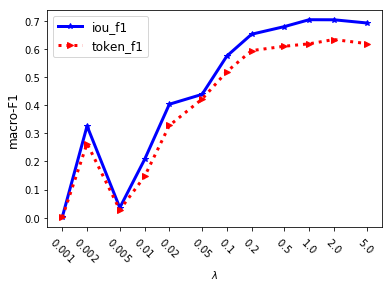

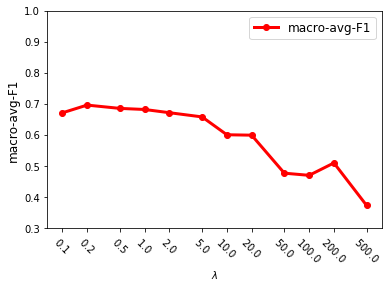

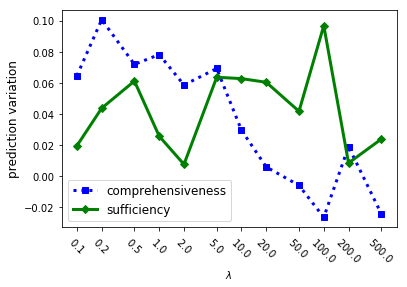

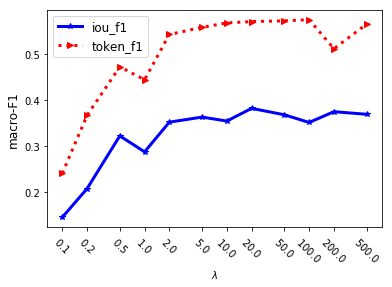

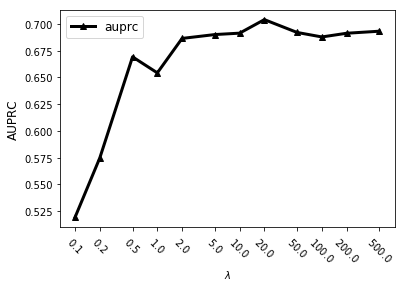

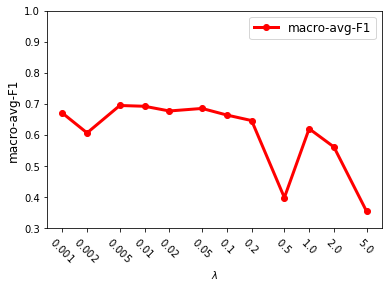

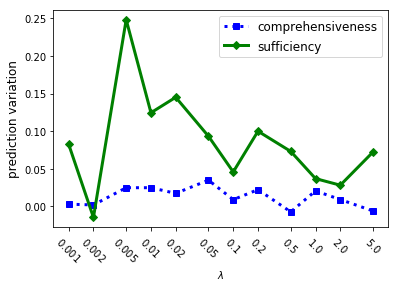

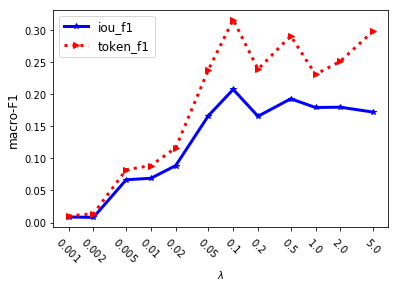

In [29]:
for dataset in ['movies', 'fever', 'multirc']:
    for structure in ['gru', 'rnr']:
        if structure == 'gru':
            par_lambdas = [0.1, 0.2, 0.5, 1., 2.,
                           5., 10., 20., 50., 100., 200., 500.]
        elif structure == 'rnr':
            par_lambdas = [0.001, 0.002, 0.005, 0.01,
                           0.02, 0.05, 0.1, 0.2, 0.5, 1., 2., 5.]
        if dataset == 'movies':
            baseline = {'macro-avg-F1': 0.974, 'sufficiency':  0.035, 'comprehensiveness': 0.113,
                        'auprc':  0.467, "iou_f1": 0.124, 'token_f1': 0.322}
            train_on_portion = 0
        elif dataset == 'fever':
            baseline = {'macro-avg-F1': 0.850, 'sufficiency':  0.077, 'comprehensiveness': 0.070,
                        'auprc':  0.617, "iou_f1": 0.817, 'token_f1': 0.796}
            train_on_portion = 0.1
        elif dataset == 'multirc':
            baseline = {'macro-avg-F1': 0.655,
                        'sufficiency': 0.079,
                        'comprehensiveness': 0.164,
                        'auprc': 0.240,
                        'iou_f1': 0.419,
                        "token_f1": 0.456}
            train_on_portion = 0.4
        train_on_portion_str = str(train_on_portion).replace('.', '_')
        results_dirs = [
            output_dir + f"bert_base_seqlen_512_{dataset}_exp_output_{structure}_merged_evidences{'_train_on_portion_'+str(train_on_portion) if train_on_portion != 0 else ''}_par_lambda_{par_lambda}_no_padding_imbalanced_bce_resampling_pooling_first_learning_rate_1e-05__{split}.txt" for par_lambda in par_lambdas]

        for results_dir in results_dirs:
            if not os.path.isfile(results_dir):
                print(results_dir)

        metrics = ['macro-avg-F1']
        results = []
        y = {metric: [] for metric in metrics}
        for results_dir in results_dirs:
            if os.path.isfile(results_dir):
                with open(results_dir, 'r') as fin:
                    r = eval(fin.read()[1:-1])
                results.append(r)
                for metric in metrics:
                    y[metric].append(r['classification_scores']
                                     ['prf']['macro avg']['f1-score'])
            else:
                for metric in metrics:
                    y[metric].append(0)
        fig, ax = plt.subplots()
        plt.xlabel("$\lambda$")
        plt.ylabel("macro-avg-F1", fontsize='large')
        plt.xticks([math.log(i) for i in par_lambdas], [("$"+str(l)+"$")
                                                        for l in par_lambdas], rotation=-45)
        for metric in metrics:
            #plt.axhline(y=baseline[metric], color=color[metric],
            #            linestyle=linestyles[metric], linewidth=linewidth//2, label=metric+'-baseline')
            ax.plot([math.log(i) for i in par_lambdas], y[metric], label=metric,
                    color=color[metric], linestyle=linestyles[metric], linewidth=linewidth, marker=markers[metric])
        plt.ylim([0.3, 1])
        ax.legend(fontsize='large')
        plt.savefig(
            img_dir + f'{dataset}_{structure}_{split}_train_on_portion_{train_on_portion_str}_macro_avg_f1.png', dpi=300)

        metrics = ["comprehensiveness", 'sufficiency']
        results = []
        y = {metric: [] for metric in metrics}
        for results_dir in results_dirs:
            if os.path.isfile(results_dir):
                with open(results_dir, 'r') as fin:
                    r = eval(fin.read()[1:-1])
                results.append(r)
                for metric in metrics:
                    y[metric].append(r['classification_scores'][metric])
            else:
                for metric in metrics:
                    y[metric].append(0)

        fig, ax = plt.subplots()
        plt.xlabel("$\lambda$")
        plt.xticks([math.log(i) for i in par_lambdas], [("$"+str(l)+"$")
                                                        for l in par_lambdas], rotation=-45)
        plt.ylabel("prediction variation", fontsize='large')
        for metric in metrics:
            #plt.axhline(y=baseline[metric], color=color[metric],
            #            linestyle=linestyles[metric], linewidth=linewidth//2, label=metric+'-baseline')
            ax.plot([math.log(i) for i in par_lambdas], y[metric], label=metric,
                    color=color[metric], linestyle=linestyles[metric], linewidth=linewidth, marker=markers[metric])
        ax.legend(fontsize='large')
        plt.savefig(
            img_dir + f'{dataset}_{structure}_{split}_train_on_portion_{train_on_portion_str}_cs.png', dpi=300)

        fig, ax = plt.subplots()
        #plt.axhline(y=baseline['iou_f1'], color='b', linestyle='-', linewidth=linewidth//2, label='iou_f1-baseline')
        ax.plot([math.log(i) for i in par_lambdas], [results[i]['iou_scores'][0]['macro']['f1']
                                                     for i in range(len(par_lambdas))], label='iou_f1', color='b', linewidth=linewidth, marker='*')
        #plt.axhline(y=baseline['token_f1'], color='r', linestyle=':', linewidth=linewidth//2, label='token_f1-baseline')
        ax.plot([math.log(i) for i in par_lambdas], [results[i]['token_prf']['instance_macro']['f1']
                                                     for i in range(len(par_lambdas))], label='token_f1', color='r', linestyle=':', linewidth=linewidth, marker='>')
        plt.xlabel("$\lambda$")
        plt.ylabel("macro-F1", fontsize='large')
        plt.xticks([math.log(i) for i in par_lambdas], [("$"+str(l)+"$")
                                                        for l in par_lambdas], rotation=-45)
        ax.legend(fontsize='large')
        plt.savefig(
            img_dir + f'{dataset}_{structure}_{split}_train_on_portion_{train_on_portion_str}_iou_token_f1.png', dpi=300)

        if structure == 'gru':
            metrics = ['auprc']
            rs = []
            y = {metric: [] for metric in metrics}
            for results_dir in results_dirs:
                if os.path.isfile(results_dir):
                    with open(results_dir, 'r') as fin:
                        r = fin.read()
                        r = eval(r[1:-1])
                    rs.append(r)
                    for metric in metrics:
                        y[metric].append(r['token_soft_metrics'][metric])
                else:
                    for metric in metrics:
                        y[metric].append(0)

            fig, ax = plt.subplots()
            plt.xlabel("$\lambda$")
            plt.ylabel("AUPRC", fontsize='large')
            plt.xticks([math.log(i) for i in par_lambdas], [
                       ("$"+str(l)+"$") for l in par_lambdas], rotation=-45)
            for metric in metrics:
                #plt.axhline(
                #    y=baseline[metric], color=color[metric], linestyle='-', linewidth=linewidth//2, label=metric+'-baseline')
                ax.plot([math.log(i) for i in par_lambdas], y[metric],
                        label=metric, color=color[metric], linewidth=linewidth, marker=markers[metric])
            #plt.ylim([0.5, 1])
            ax.legend(fontsize='large')
            plt.savefig(
                img_dir + f'{dataset}_{structure}_{split}_train_on_portion_{train_on_portion_str}_auprc.png', dpi=300)

In [38]:
output_folder = 'lamda_sweep_data'
results_folder = 'eraserbenchmark/outputs/lambda_sweep/'
import pandas as pd
import os
#os.mkdir(output_folder)
datasets = ['movies', 'fever', 'multirc']
train_on_portions = [0, 0.1, 0.4]
structures = ['gru', 'rnr']
par_lambdases = [[0.1, 0.2, 0.5, 1., 2., 5., 10., 20., 50., 100., 200., 500.], 
                 [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1., 2., 5.]]

split = 'val'

for dataset, train_on_portion in zip(datasets, train_on_portions):
    for structure, par_lambdas in zip(structures, par_lambdases):
        ret = {'lambda': [], 
               'macro-avg-f1': [],
               'comprehensiveness': [],
               'sufficiency': [],
               'token-f1': [],
               'iou-f1':[]}
        if structure == 'gru':
            ret['AUPRC'] = []
        train_on_portion_str = str(train_on_portion).replace('.', '_')
        trp = '_train_on_portion_'+str(train_on_portion) if train_on_portion != 0 else ''
        results_dirs = [results_folder + f"bert_base_seqlen_512_{dataset}_exp_output_{structure}_merged_evidences{trp}_par_lambda_{par_lambda}_no_padding_imbalanced_bce_resampling_pooling_first_learning_rate_1e-05__{split}.txt" for par_lambda in par_lambdas]
        for par_lambda, results_dir in zip(par_lambdas, results_dirs):
            with open(results_dir, 'r') as fin:
                r = eval(fin.read()[1:-1])
            results.append(r)
            ret['lambda'].append(par_lambda)
            ret['macro-avg-f1'].append(r['classification_scores']['prf']['macro avg']['f1-score'])
            if structure == 'gru':
                ret['AUPRC'].append(r['token_soft_metrics']['auprc'])
            ret['comprehensiveness'].append(r['classification_scores']['comprehensiveness'])
            ret['sufficiency'].append(r['classification_scores']['sufficiency'])
            ret['token-f1'].append(r['iou_scores'][0]['macro']['f1'])
            ret['iou-f1'].append(r['token_prf']['instance_macro']['f1'])
        output_dir = f'dataset_{dataset}_train_on_portion_{train_on_portion}_structure_{structure}.tsv'
        ret = pd.DataFrame(ret)
        ret.to_csv(os.path.join(output_folder, output_dir), index=None, sep='\t')

In [208]:
list(zip(par_lambdas, [math.log(i) for i in par_lambdas]))

[(0.001, -6.907755278982137),
 (0.002, -6.214608098422191),
 (0.005, -5.298317366548036),
 (0.01, -4.605170185988091),
 (0.02, -3.912023005428146),
 (0.05, -2.995732273553991),
 (0.1, -2.3025850929940455),
 (0.2, -1.6094379124341003),
 (0.5, -0.6931471805599453),
 (1.0, 0.0),
 (2.0, 0.6931471805599453),
 (5.0, 1.6094379124341003)]

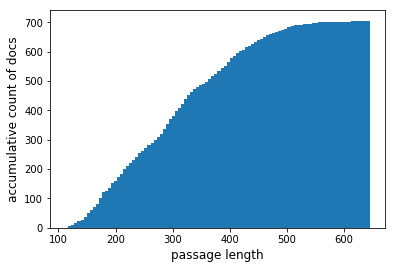

In [66]:
dataset = 'multirc'
docs_folder = '/home/zzhang/.keras/datasets/' + dataset + '/docs/'

ret = []

for fname in os.listdir(docs_folder):
    with open(docs_folder + fname, 'r') as fin:
        lines = fin.readlines()
    lines = ' '.join(lines).split()
    ret.append(len(lines))

plt.xlabel('passage length', fontsize='large')
plt.ylabel('accumulative count of docs', fontsize='large')
plt.hist(ret, bins=100, cumulative=True)
plt.savefig(img_dir + f'{dataset}_accumulative_hist.png', dpi=300)